In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import proplot as pplt

import torch
import torch.nn as nn

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

current_path = !pwd
parent_path = os.path.dirname(current_path[0])
if parent_path not in sys.path: sys.path.append(parent_path)

import utils.model_handling as model_utils
import utils.dataset_generation as iso_data
import utils.histogram_analysis as hist_funcs
import utils.principal_curvature as curve_utils
import utils.plotting as plot_funcs

In [2]:
class QuadraticFunction(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hessian = torch.tensor([[1.0, 0.0], [0.0, 2.0]]).to(DEVICE)
    
    def forward(self, x):
        return torch.dot(x, torch.matmul(self.hessian, x))

f = QuadraticFunction().to(DEVICE)

In [3]:
xs = torch.linspace(-3, 3, 50).to(DEVICE)
ys = torch.linspace(-3, 3, 50).to(DEVICE)
XS, YS = torch.meshgrid(xs, ys)
XS_flat = XS.flatten()
YS_flat = YS.flatten()
data = torch.vstack((XS_flat, YS_flat))
zs = torch.tensor([f(data[:, i]) for i in range(len(data.T))]).reshape(XS.shape)

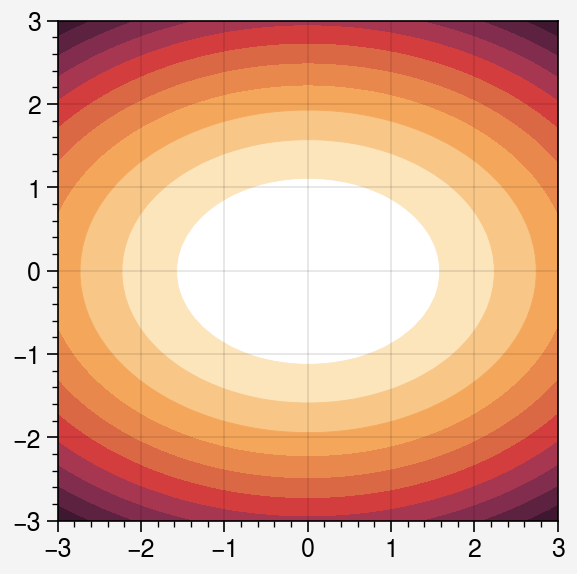

In [4]:
fig, axs = pplt.subplots(nrows=1, ncols=1)
axs.contourf(XS.cpu().numpy(), YS.cpu().numpy(), zs.cpu().numpy())

In [5]:
points = [
    [0.5, 1.0],
    [1.0, 2.0],
    [0.0, 1.0],
]

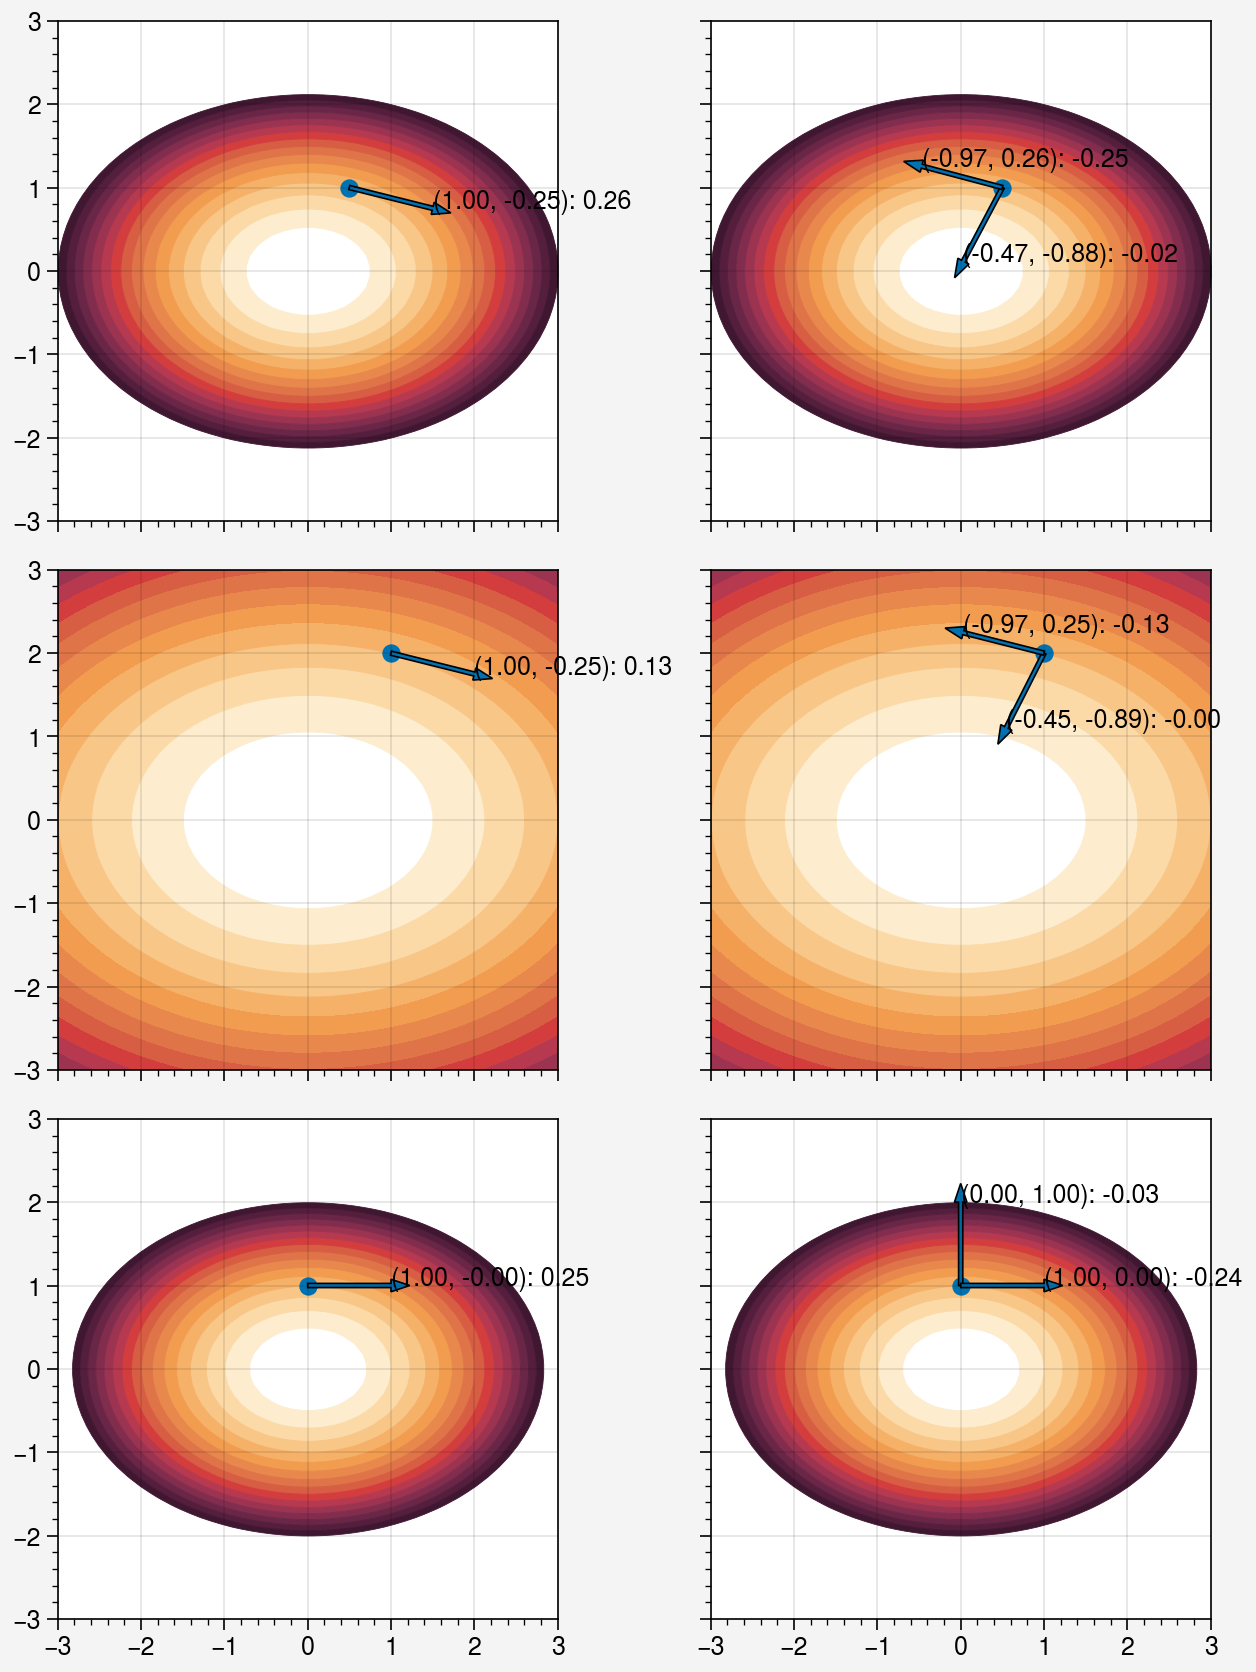

In [6]:
fig, axs = pplt.subplots(nrows=len(points), ncols=2)

def plot_curvature(ax, curvatures, directions):
    for curvature, direction in zip(curvatures.detach().cpu().numpy(), directions.T.detach().cpu().numpy()):
        ax.arrow(np_point[0], np_point[1], direction[0], direction[1], width=0.05)
        #ax.text(np_point[0] + 0.5 * direction[0], np_point[1] + 0.5 * direction[1], f'{curvature:.02f}')
        ax.text(np_point[0] + 1.0 * direction[0], np_point[1] + 1.0 * direction[1], f'({direction[0]:.02f}, {direction[1]:.02f}): {curvature:.02f}')

for point_index, np_point in enumerate(points):
    
    f.zero_grad()
    point = torch.tensor(np_point).to(DEVICE)
    value = f(point)
    pt_grad = 2*torch.matmul(f.hessian, point)
    
    for ax in axs[point_index, :]:
        ax.contourf(XS.cpu().numpy(), YS.cpu().numpy(), zs.cpu().numpy(), levels=np.linspace(0, 4, 17)*value.detach().cpu().numpy())
        ax.scatter([np_point[0]], [np_point[1]])

    
    # isoresponse
    iso_shape_operator, iso_curvatures, iso_directions = curve_utils.local_response_curvature_isoresponse_surface(pt_grad, f.hessian)
    graph_shape_operator, graph_curvatures, graph_directions = curve_utils.local_response_curvature_graph(pt_grad, f.hessian)
    plot_curvature(axs[point_index, 0], iso_curvatures, iso_directions)
    plot_curvature(axs[point_index, 1], graph_curvatures, graph_directions)